https://www.kaggle.com/c/quora-question-pairs

# Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.options.display.max_colwidth = -1
pd.options.display.max_columns = 15

import pickle

In [3]:
from tqdm.auto import tqdm
from IPython.display import clear_output
tqdm.pandas()

D:\Users\Ritvik\Anaconda3\envs\datascience\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


# Text Cleaning

In [4]:
import nltk, re
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

def spell_correct(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r"\0s", "0", text)    
    return text

def remove_url(text):
    URL_REGEX = re.compile(r'''((http[s]?://)[^ <>'"{}|\\^`[\]]*)''')
    return URL_REGEX.sub(r' ', text)

def remove_handles(text):
    HANDLES_REGEX = re.compile(r'@\S+')
    return HANDLES_REGEX.sub(r' ', text)

def remove_incomplete_last_word(text):
    INCOMPLETE_LAST_WORD_REGEX = re.compile(r'\S+…')
    return INCOMPLETE_LAST_WORD_REGEX.sub(r' ', text )
    
def remove_hashtags(text):
    HASHTAGS_REGEX = re.compile(r'#\S+')
    return HASHTAGS_REGEX.sub(r' ', text)

remove_punc = lambda x : re.sub(r"\W", ' ', x)

remove_num = lambda x : re.sub(r"\d", ' ', x)

remove_extra_spaces = lambda x : re.sub(r"\s+", ' ', x)

lower_case = lambda x : x.lower()

remove_shortwords = lambda x: ' '.join(word for word in x.split() if len(word) > 2)

with open('stopwords.txt') as f:
    sw = map(lambda x : x.strip(), f.readlines())
stop_words = set(nltk.corpus.stopwords.words('english'))|set(sw)
remove_stopwords = lambda x: ' '.join(word for word in x.split() if word not in stop_words)

ps = PorterStemmer()
ps_stem = lambda x: ' '.join(ps.stem(word) for word in x.split())

wnl = WordNetLemmatizer()
wnl_lemmatize = lambda x: ' '.join(wnl.lemmatize(word) for word in x.split())

def tag_pos(x):
    tag_list =  nltk.pos_tag(nltk.word_tokenize(x))
    pos = ""
    for t in tag_list:
        pos += t[0] +'(' + t[1] +')' + ' '
    return pos

def cleanText(x, rsw, stm, lem, tgps):
    x = str(x)
    x = remove_url(x)
    x = remove_handles(x)
    x = remove_incomplete_last_word(x)
    x = remove_hashtags(x)
    x = lower_case(x)
    x = spell_correct(x)
    x = remove_punc(x)
    x = remove_num(x)
    x = remove_extra_spaces(x)
    x = remove_shortwords(x)
    
    if rsw:
        x = remove_stopwords(x)
    if stm:
        x = ps_stem(x)
    if lem:
        x = wnl_lemmatize(x)
    if tgps:
        x = tag_pos(x)
    return x

# Data

In [5]:
train = pd.read_csv('../[Data]-Quora-Question-Pairs/train.csv')

In [6]:
train.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in share market in india?,What is the step by step guide to invest in share market?,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Diamond?,What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?,0
2,2,5,6,How can I increase the speed of my internet connection while using a VPN?,How can Internet speed be increased by hacking through DNS?,0
3,3,7,8,Why am I mentally very lonely? How can I solve it?,"Find the remainder when [math]23^{24}[/math] is divided by 24,23?",0
4,4,9,10,"Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?",Which fish would survive in salt water?,0


Target Class Distribution


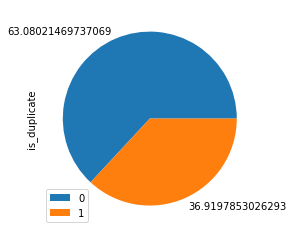

In [7]:
print('Target Class Distribution')
class_distribution = train['is_duplicate'].value_counts(normalize=True).mul(100)
class_distribution.plot.pie(labels=class_distribution)
plt.legend(class_distribution.index)

In [8]:
nan_rows = train[train.isnull().any(1)]
print (nan_rows)
train = train.fillna(' ')

            id    qid1    qid2                         question1  \
105780  105780  174363  174364  How can I develop android app?     
201841  201841  303951  174364  How can I create an Android app?   
363362  363362  493340  493341  NaN                                

                                                                                                                          question2  \
105780  NaN                                                                                                                           
201841  NaN                                                                                                                           
363362  My Chinese name is Haichao Yu. What English name is most suitable for me considering the pronounciation of my Chinese name?   

        is_duplicate  
105780  0             
201841  0             
363362  0             


In [9]:
qids = pd.Series(train['qid1'].tolist() + train['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print (f'Total number of  Unique Questions are: {unique_qs}')

print (f'Number of unique questions that appear more than one time: {qs_morethan_onetime} ({qs_morethan_onetime/unique_qs*100:.2f}%)')

print (f'Max number of times a single question is repeated: {max(qids.value_counts())}') 

Total number of  Unique Questions are: 537933
Number of unique questions that appear more than one time: 111780 (20.78%)
Max number of times a single question is repeated: 157


Maximum number of times a single question is repeated: 157



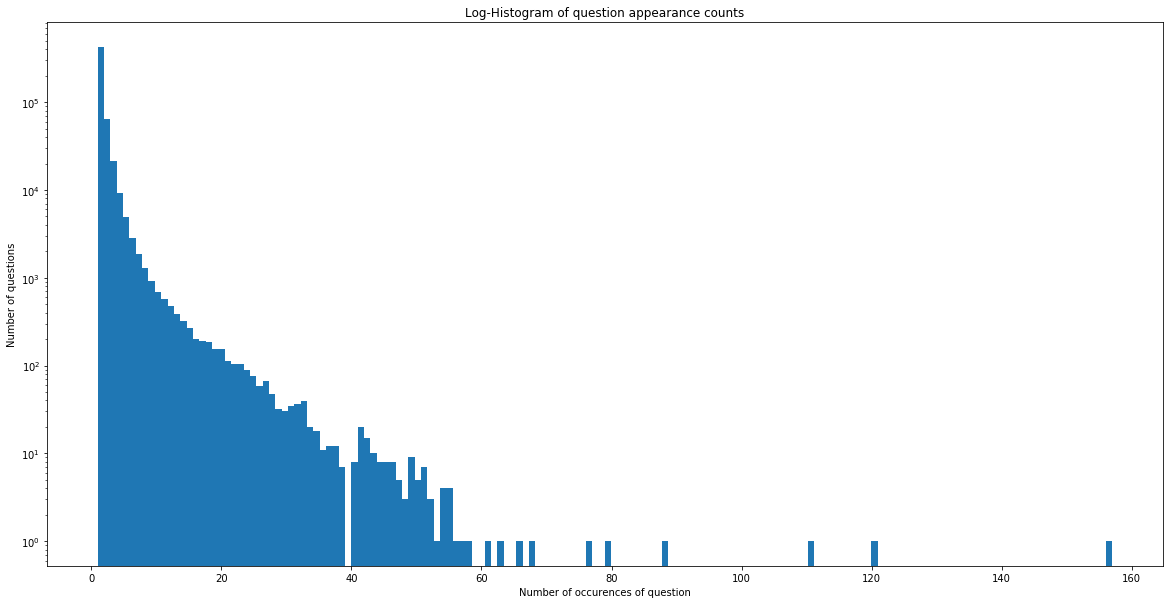

In [10]:
plt.figure(figsize=(20, 10))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')
print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

In [11]:
del qids

In [12]:
test = pd.read_csv('../[Data]-Quora-Question-Pairs/test.csv')

In [13]:
test.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare with iPad Pro?,Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?
1,1,Should I have a hair transplant at age 24? How much would it cost?,How much cost does hair transplant require?
2,2,What but is the best way to send money from China to the US?,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


# EDA

D:\Users\Ritvik\Anaconda3\envs\datascience\lib\site-packages\matplotlib\axes\_axes.py:6510: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


mean-train 59.82 (31.96)
mean-test 60.07 (31.62)
max-train 1169.00 max-test 1176.00


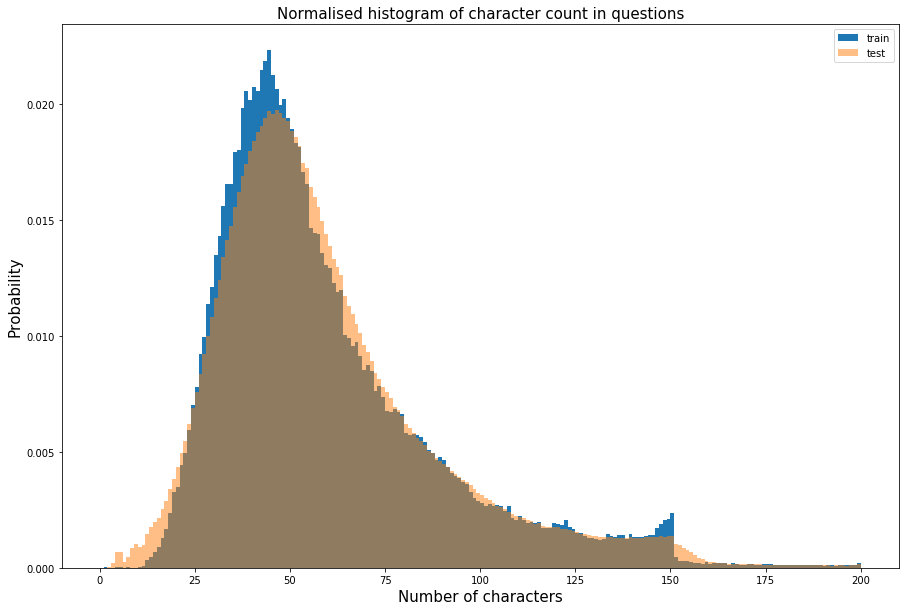

In [14]:
train_qs = pd.Series(train['question1'].tolist() + train['question2'].tolist()).astype(str)
test_qs = pd.Series(test['question1'].tolist() + test['question2'].tolist()).astype(str)

dist_train = train_qs.progress_apply(len)
dist_test = test_qs.progress_apply(len)

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of character count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print(f'mean-train {dist_train.mean():.2f} ({dist_train.std():.2f})\nmean-test {dist_test.mean():.2f} ({dist_test.std():.2f})\nmax-train {dist_train.max():.2f} max-test {dist_test.max():.2f}')


mean-train 11.06 (5.88)
mean-test 11.02 (5.85)
max-train 237.00 max-test 238.00


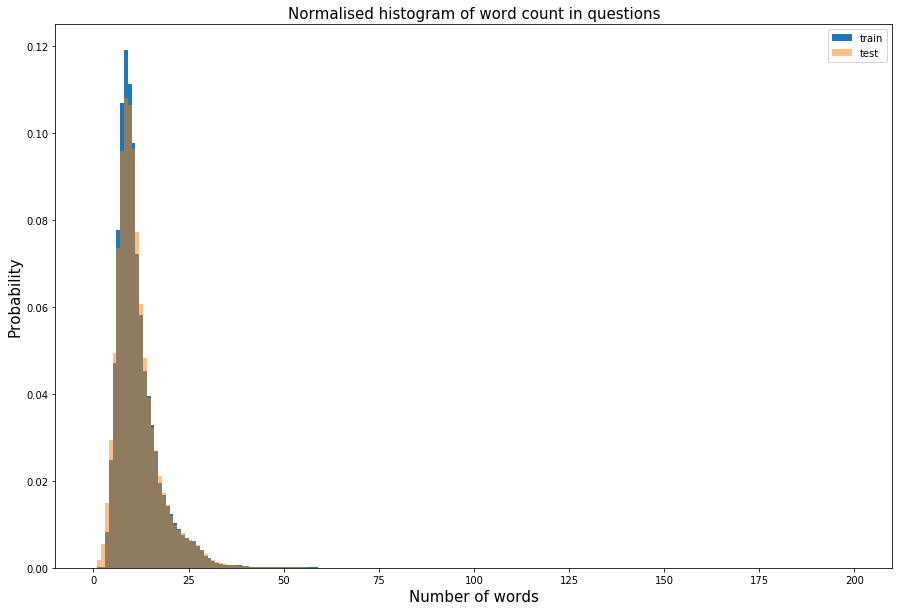

In [15]:
dist_train = train_qs.progress_apply(lambda x: len(x.split()))
dist_test = test_qs.progress_apply(lambda x: len(x.split()))

plt.figure(figsize=(15, 10))
plt.hist(dist_train, bins=200, range=[0, 200], normed=True, label='train')
plt.hist(dist_test, bins=200, range=[0, 200], normed=True, alpha=0.5, label='test')
plt.title('Normalised histogram of word count in questions', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

print(f'mean-train {dist_train.mean():.2f} ({dist_train.std():.2f})\nmean-test {dist_test.mean():.2f} ({dist_test.std():.2f})\nmax-train {dist_train.max():.2f} max-test {dist_test.max():.2f}')

**Semantic Analysis**

In [16]:
print(f"Questions with question marks: {np.mean(train_qs.progress_apply(lambda x: '?' in x))*100:.2f}%")
print(f"Questions with [math] tags: {np.mean(train_qs.progress_apply(lambda x: '[math]' in x))*100:.2f}%")
print(f"Questions with full stops: {np.mean(train_qs.progress_apply(lambda x: '.' in x))*100:.2f}%")
print(f"Questions with capitalised first letters: {np.mean(train_qs.progress_apply(lambda x: x[0].isupper()))*100:.2f}%")
print(f"Questions with capital letters: {np.mean(train_qs.progress_apply(lambda x: max([y.isupper() for y in x])))*100:.2f}%")
print(f"Questions with numbers: {np.mean(train_qs.progress_apply(lambda x: max([y.isdigit() for y in x])))*100:.2f}%")


Questions with question marks: 99.87%



Questions with [math] tags: 0.12%



Questions with full stops: 6.31%



Questions with capitalised first letters: 99.81%



Questions with capital letters: 99.95%



Questions with numbers: 11.83%


In [17]:
del train_qs, test_qs, dist_train, dist_test

# BaseLine Model

As we have seen that we have a 36.91% positive class in this dataset. Since we are using the LogLoss metric, and LogLoss looks at the actual predicts as opposed to the order of predictions, we should be able to get a decent score by creating a submission predicting the mean value of the label.

In [18]:
from sklearn.metrics import log_loss

p = train['is_duplicate'].mean()
print('Predicted score:', log_loss(train['is_duplicate'], np.zeros_like(train['is_duplicate']) + p))

# sub = pd.DataFrame({'test_id': test['test_id'], 'is_duplicate': p})
del p

Predicted score: 0.6585273839844354


**0.55 on the leaderboard! Score!**

# Feature Extraction

In [19]:
train.drop(['id', 'qid1', 'qid2'], axis=1, inplace=True)
test.drop(['test_id'], axis=1, inplace=True)

In [20]:
print('Merging all questions')
all_question = pd.concat([train['question1'], train['question2'], test['question1'], test['question2']], axis=0)
all_question = all_question.reset_index(drop=True)
all_question.head()

Merging all questions


0    What is the step by step guide to invest in share market in india?          
1    What is the story of Kohinoor (Koh-i-Noor) Diamond?                         
2    How can I increase the speed of my internet connection while using a VPN?   
3    Why am I mentally very lonely? How can I solve it?                          
4    Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?
dtype: object

* text cleaning

In [21]:
tqdm.pandas()
all_question = all_question.progress_apply(lambda x : cleanText(x, True, False, False, False))

D:\Users\Ritvik\Anaconda3\envs\datascience\lib\site-packages\tqdm\std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [22]:
train['question1'] = all_question[:404290]
train['question2'] = all_question[404290:2*404290].reset_index(drop=True)
test['question1'] = all_question[2*404290:2*404290+2345796].reset_index(drop=True)
test['question2'] = all_question[2*404290+2345796:].reset_index(drop=True)

* TFIDF Vectors
* Cosine Similarity of TFIDF Vectors

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.metrics.pairwise import cosine_similarity

In [38]:
tfidfVectorizer = TfidfVectorizer()

tfidfVectorizer.fit(all_question)
del all_question

In [ ]:
vect_train_q1 = tfidfVectorizer.transform(train['question1'])
vect_train_q2 = tfidfVectorizer.transform(train['question2'])
train['Cosine'] = cosine_similarity(vect_train_q1,vect_train_q2)

del vect_train_q1, vect_train_q2

In [ ]:
vect_test_q1 = tfidfVectorizer.transform(test['question1'])
vect_test_q2 = tfidfVectorizer.transform(test['question2'])
test['Cosine'] = cosine_similarity(vect_test_q1,vect_test_q2)

del vect_test_q1, vect_test_q2

In [39]:
pickle.dump(tfidfVectorizer, open('../[Data]-Quora-Question-Pairs/tfidfVectorizer.pkl', 'wb'))

* Jaccard Similarity
* Fuzz Ratio
* Fuzz Partial Ratio
* Fuzz Token Sort Ratio
* Fuzz Token Set Ratio

In [23]:
from fuzzywuzzy import fuzz

D:\Users\Ritvik\Anaconda3\envs\datascience\lib\site-packages\fuzzywuzzy\fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [24]:
def jaccard_similarity(q1, q2):
    q1 = set(q1.split())
    q2 = set(q2.split())
    try:
        return (len(q1&q2)/len(q1|q2))*100
    except:
        return 0
    
feature = []
for q1, q2 in tqdm(zip(train['question1'], train['question2'])):
    feature.append(jaccard_similarity(q1, q2))
train['Jaccard'] = feature

feature = []
for q1, q2 in tqdm(zip(test['question1'], test['question2'])):
    feature.append(jaccard_similarity(q1, q2))
test['Jaccard'] = feature

is_duplicate
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Jaccard, dtype: object

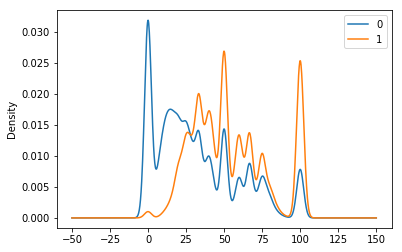

In [25]:
train.groupby('is_duplicate')['Jaccard'].plot(kind='density', legend=True)

In [26]:
feature = []
for q1, q2 in tqdm(zip(train['question1'], train['question2'])):
    try:
        feature.append(fuzz.ratio(q1, q2))
    except:
        feature.append(0)
train['Fuzz Ratio'] = feature

feature = []
for q1, q2 in tqdm(zip(test['question1'], test['question2'])):
    try:
        feature.append(fuzz.ratio(q1, q2))
    except:
        feature.append(0)
test['Fuzz Ratio'] = feature

is_duplicate
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Fuzz Ratio, dtype: object

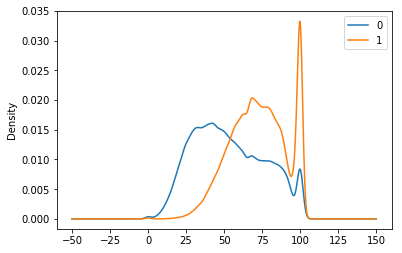

In [27]:
train.groupby('is_duplicate')['Fuzz Ratio'].plot(kind='density', legend=True)

In [28]:
feature = []
for q1, q2 in tqdm(zip(train['question1'], train['question2'])):
    try:
        feature.append(fuzz.partial_ratio(q1, q2))
    except:
        feature.append(0)
train['Fuzz Partial Ratio'] = feature

feature = []
for q1, q2 in tqdm(zip(test['question1'], test['question2'])):
    try:
        feature.append(fuzz.partial_ratio(q1, q2))
    except:
        feature.append(0)
test['Fuzz Partial Ratio'] = feature

is_duplicate
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Fuzz Partial Ratio, dtype: object

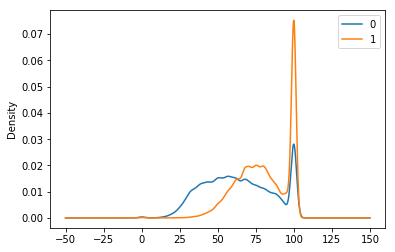

In [29]:
train.groupby('is_duplicate')['Fuzz Partial Ratio'].plot(kind='density', legend=True)

In [30]:
feature = []
for q1, q2 in tqdm(zip(train['question1'], train['question2'])):
    try:
        feature.append(fuzz.token_sort_ratio(q1, q2))
    except:
        feature.append(0)
train['Fuzz Token Sort Ratio'] = feature

feature = []
for q1, q2 in tqdm(zip(test['question1'], test['question2'])):
    try:
        feature.append(fuzz.token_sort_ratio(q1, q2))
    except:
        feature.append(0)
test['Fuzz Token Sort Ratio'] = feature

is_duplicate
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Fuzz Token Sort Ratio, dtype: object

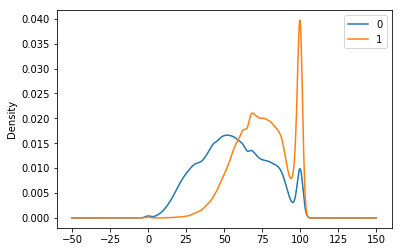

In [31]:
train.groupby('is_duplicate')['Fuzz Token Sort Ratio'].plot(kind='density', legend=True)

In [32]:
feature = []
for q1, q2 in tqdm(zip(train['question1'], train['question2'])):
    try:
        feature.append(fuzz.token_set_ratio(q1, q2))
    except:
        feature.append(0)
train['Fuzz Token Set Ratio'] = feature

feature = []
for q1, q2 in tqdm(zip(test['question1'], test['question2'])):
    try:
        feature.append(fuzz.token_set_ratio(q1, q2))
    except:
        feature.append(0)
test['Fuzz Token Set Ratio'] = feature

is_duplicate
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: Fuzz Token Set Ratio, dtype: object

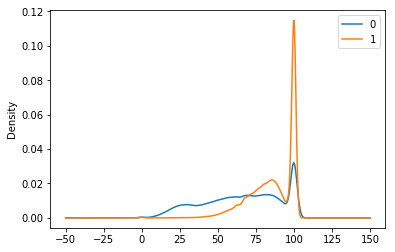

In [33]:
train.groupby('is_duplicate')['Fuzz Token Set Ratio'].plot(kind='density', legend=True)

In [36]:
train.to_csv('../[Data]-Quora-Question-Pairs/train_feats.csv', index=False)
test.to_csv('../[Data]-Quora-Question-Pairs/test_feats.csv', index=False)